In [1]:
import csv 
import numpy as np 
import pandas as pd
import sys
import os
import psutil

from matplotlib import cm
import matplotlib.pyplot as plt
import plotly.express as px 

plt.rcParams['figure.figsize'] = [12, 10]
%matplotlib inline

In [2]:
target_file = '../data/cluster_outputs/riot_games_LOL/v2/756260657.csv'

dat = []

with open(target_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            dat.append(row)
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are sent_time, raw_chat_message, processed_chat_message, cluster_num, x, y
Processed 83398 lines.


In [3]:
dat = pd.DataFrame(dat, columns = ['time', 'msg', 'msg_clean', 'cluster', 'x', 'y'])

In [4]:
window=1
busiest_minute = 213
persistence = 5

start_time = (busiest_minute*60)-((window-1)*60*0.5)
end_time = start_time+(window*60)

print(start_time, end_time)

12780.0 12840.0


In [5]:
def raw_time(row):
    time_split = [float(x) for x in row.split(':')]
    return time_split[0]*3600+time_split[1]*60+time_split[2]

def round_zero(time, base):
    return round(round(time, 1) - base, 1)

In [6]:
dat['raw_time'] = dat.apply(lambda row : raw_time(row['time']), 
                                  axis=1)

df_1min = dat[(dat['raw_time'] > start_time) & 
              (dat['raw_time'] < end_time)].reset_index()

base_time = round(df_1min['raw_time'][0], 1)

df_1min['time_rounded_zeroed'] = df_1min.apply(lambda row : round_zero(row['raw_time'],
                                                                  base_time), 
                                  axis=1)

df = df_1min[['msg_clean', 'cluster', 'x', 'y', 'time_rounded_zeroed']]
df.head()

,msg_clean,cluster,x,y,time_rounded_zeroed
0,bye oce,9,-0.11226242,-0.48036543,0.0
1,blundered Kreygasm,3,-0.53293884,-0.43837976,0.2
2,bye oce,9,-0.11226242,-0.48036543,0.6
3,oce silenced,4,-0.26730612,0.1749508,1.2
4,sadge,0,-1.1030256,-1.120396,1.7


In [12]:
timeline = [round(x,1) for x in np.linspace(0,window*60, window*60*10+1)]

df_plot = pd.DataFrame(columns=df.columns)
for time in timeline: 
    tmp = df[(df['time_rounded_zeroed'] >= max(0, time-persistence)) & 
             (df['time_rounded_zeroed'] <= time)].reset_index()
    tmp['time_frame'] = time
    df_plot = df_plot.append(tmp, ignore_index = True)

In [14]:
print(df_plot[df_plot['time_frame'] == 40.1])

                             msg_clean cluster            x              y  \
8287                                gg       0   -1.1821564     -0.5584184   
8288                           EZ Clap       5   -0.3273211      0.5354494   
8289                          sadge gg       9   -0.7022841     -1.0900956   
8290                         n\1\1 oce       4  -0.31103122     -0.5715036   
8291  RIP oce hopes gone feelsweirdman       4    1.0902641  -0.0023778745   
...                                ...     ...          ...            ...   
8344                           bye oce       9  -0.11226242    -0.48036543   
8345                        kramer god       5  -0.15110172     0.14934067   
8346                                gg       0   -1.1821564     -0.5584184   
8347                      oce silenced       4  -0.26730612      0.1749508   
8348                           bye oce       9  -0.11226242    -0.48036543   

      time_rounded_zeroed  index  time_frame  
8287            

msg_clean               object
cluster                 object
x                      float64
y                      float64
time_rounded_zeroed    float64
index                  float64
time_frame             float64
dtype: object
-1.3284713 2.8316407
-2.2453423 3.386172


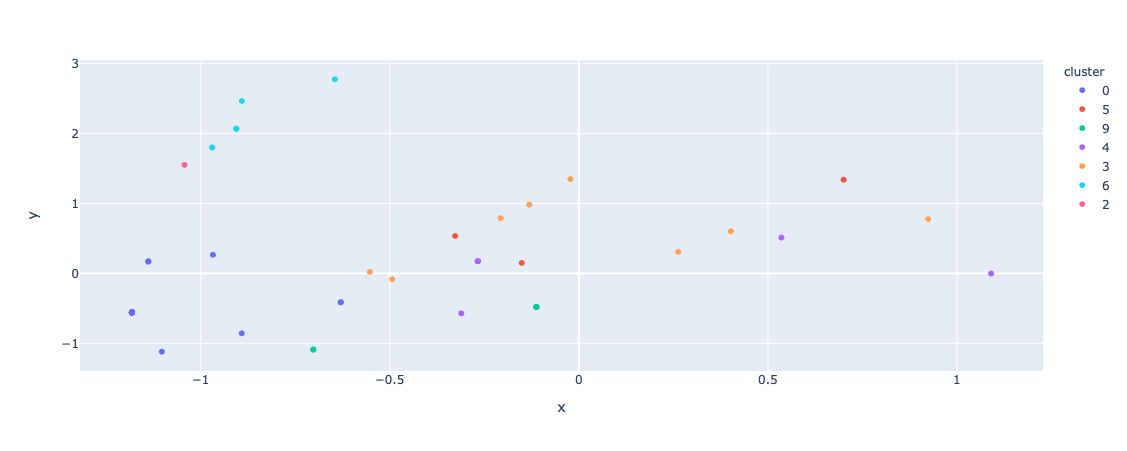

In [20]:
df_plot['x'] = df_plot.x.astype(float)
df_plot['y'] = df_plot.y.astype(float)
print(df_plot.dtypes)
print(min(df_plot['x']), max(df_plot['x']))
print(min(df_plot['y']), max(df_plot['y']))

x_min, x_max = min(df_plot['x']), max(df_plot['x'])
y_min, y_max = min(df_plot['y']), max(df_plot['y'])

px.scatter(df_plot[df_plot['time_frame'] == 40.1], x="x", y="y", color="cluster")

In [11]:
fig = px.scatter(df_plot[df_plot['time_frame'] < 10], x="x", y="y", animation_frame="time_frame",
           color="cluster")

fig.write_image("fig1.png")

In [50]:
if not os.path.exists("images"):
    os.mkdir("images")
    
counter = 0    

colors = ["#0b132b","#1c2541","#3a506b","#5bc0be","#ffffff","#b56576","#e56b6f","#eaac8b","#b33f62","#f9564f"]

color_map={}

for i in range(10):
    color_map[f"{i}"] = colors[i]
    
print(color_map)

for frame in timeline: 
    fig = px.scatter(df_plot[df_plot['time_frame'] == frame], x="x", y="y",
                     color="cluster", 
                     text="msg_clean",
                    range_x=[x_min-0.1,x_max+0.1], range_y=[y_min-0.1,y_max+0.1],
                    color_discrete_map=color_map)
    
    fig.update_traces(textposition='top center')

    fig.write_image(f"images/{counter}_frame.png")
    counter+=1

{'0': '#0b132b', '1': '#1c2541', '2': '#3a506b', '3': '#5bc0be', '4': '#ffffff', '5': '#b56576', '6': '#e56b6f', '7': '#eaac8b', '8': '#b33f62', '9': '#f9564f'}


In [ ]:
import imageio

gif_name = "first_run"
print(os.getcwd())

filenames = []
for i in range(counter): 
    filenames.append(f"./images/{i}_frame.png")

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
print(len(images), " images loaded")
imageio.mimsave(f'{gif_name}.gif', images, duration=0.1)
print('gif complete')

/Users/calvinlu/Documents/bot/TwitchSonification/visualization
601  images loaded
